In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

# Sample dataset: A few incorrect sentences and their corrected versions
data = {
    "incorrect": [
        "She go to school every day.",
        "They was playing soccer.",
        "I doesn't like tea.",
        "He have a blue car.",
        "We am very happy today."
    ],
    "corrected": [
        "She goes to school every day.",
        "They were playing soccer.",
        "I don't like tea.",
        "He has a blue car.",
        "We are very happy today."
    ]
}

df = pd.DataFrame(data)

In [3]:
#Tokenizing and padding the sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000

tokenizer = Tokenizer(num_words = vocab_size, oov_token = "<OOV>")

sentences = df["incorrect"].tolist() + df["corrected"].tolist()
tokenizer.fit_on_texts(sentences)

incorrect_sequences = tokenizer.texts_to_sequences(df["incorrect"].tolist())
correct_sequences = tokenizer.texts_to_sequences(df["corrected"].tolist())

max_length = max(max(len(seq) for seq in incorrect_sequences), max(len(seq) for seq in correct_sequences))

incorrect_padded = pad_sequences(incorrect_sequences, maxlen = max_length, padding = "post")
corrected_padded = pad_sequences(correct_sequences, maxlen = max_length, padding = "post")

print("Tokenized and padded incorrect sentences:\n", incorrect_padded)
print("Tokenized and padded incorrect sentences:\n", corrected_padded)

Tokenized and padded incorrect sentences:
 [[ 2 21  3  4  5  6]
 [ 7 22  8  9  0  0]
 [10 23 11 12  0  0]
 [13 24 14 15 16  0]
 [17 25 18 19 20  0]]
Tokenized and padded incorrect sentences:
 [[ 2 26  3  4  5  6]
 [ 7 27  8  9  0  0]
 [10 28 11 12  0  0]
 [13 29 14 15 16  0]
 [17 30 18 19 20  0]]


In [4]:
# Func for how many times they've been repeated
from collections import Counter

def find_over_repeated_words(sentence, threshold = 2):

    words = sentence.lower().split()

    word_counts = Counter(words)
    
    repeated_words = {word: count for word, count in word_counts.items() if count > threshold}
    return repeated_words

def preprocess_sentence(sentence):
    repeated_words = find_over_repeated_words(sentence)
    if repeated_words:
        print(f"Warning: Over-repeated words detected -> {repeated_words}")
    return sentence  
# Here, the sentence can still pass to Seq2Seq for further correction

# Test the function
test_sentence = "I really really really want to go to the movies movies movies."
preprocessed = preprocess_sentence(test_sentence)
print("Processed Sentence:", preprocessed)

Processed Sentence: I really really really want to go to the movies movies movies.


In [5]:
import re

def find_punctuation_errors(sentence):
    double_punctuation = re.findall(r'([!?.,])\1+', sentence)
    misplaced_commas = re.findall(r'(^,|,,| ,)', sentence)
    
    errors = {}
    if double_punctuation:
        errors['double_punctuation'] = double_punctuation
    if misplaced_commas:
        errors['misplaced_commas'] = misplaced_commas
    
    return errors

def preprocess_sentence_with_punctuation(sentence):
    punctuation_errors = find_punctuation_errors(sentence)
    if punctuation_errors:
        print(f"Warning: Punctuation errors detected -> {punctuation_errors}")
    return sentence  # Still passes through Seq2Seq for overall correction

# Test the function
test_sentence = "I love coding!! But, sometimes,, it is tricky."
preprocessed = preprocess_sentence_with_punctuation(test_sentence)
print("Processed Sentence:", preprocessed)

Processed Sentence: I love coding!! But, sometimes,, it is tricky.


In [6]:
import pandas as pd


def combined_preprocess(sentence):
    repeated_words = find_over_repeated_words(sentence)
    if repeated_words:
        print(f"Over-repeated words detected: {repeated_words}")
    
    punctuation_errors = find_punctuation_errors(sentence)
    if punctuation_errors:
        print(f"Punctuation errors detected: {punctuation_errors}")
    
    return sentence

# Test combined preprocessing
test_sentence = "I went to the the the supermarket!! And, then, then I bought bought apples."
preprocessed = combined_preprocess(test_sentence)
print("Processed Sentence:", preprocessed)

#Data for combined functions
data = {
    "incorrect": [
        "I really really like this!! But, but sometimes it’s tricky.",
        "The the the dog is running fast fast fast.",
    ],
    "corrected": [
        "I really like this! But sometimes it’s tricky.",
        "The dog is running fast.",
    ]
}
df = pd.DataFrame(data)

# corrections from functions
def highlight_corrections(original, corrected):
    original_words = original.split()
    corrected_words = corrected.split()
    
    changes = []
    for i, (o, c) in enumerate(zip(original_words, corrected_words)):
        if o != c:
            changes.append((i, o, c))
    
    if changes:
        for idx, orig, corr in changes:
            print(f"Word changed at position {idx}: '{orig}' -> '{corr}'")
    else:
        print("No changes detected.")

def explain_and_print_corrections(original, corrected):
    """
    Compare the original and corrected sentences, highlight changes,
    and print the processed sentence.
    """
    original_words = original.split()
    corrected_words = corrected.split()
    
    changes = []
    for i, (o, c) in enumerate(zip(original_words, corrected_words)):
        if o != c:
            changes.append((i, o, c))
    
    print("Processed Sentence:")
    print(corrected)
    
    if changes:
        print("\nChanges made:")
        for idx, orig, corr in changes:
            print(f" - Word changed at position {idx}: '{orig}' -> '{corr}'")
    else:
        print("\nNo changes were necessary.")

original_sentence = "I really really like this!! But, but sometimes it’s tricky."

corrected_sentence = "I really like this! But sometimes it’s tricky."

explain_and_print_corrections(original_sentence, corrected_sentence)

Over-repeated words detected: {'the': 3}
Punctuation errors detected: {'double_punctuation': ['!']}
Processed Sentence: I went to the the the supermarket!! And, then, then I bought bought apples.
Processed Sentence:
I really like this! But sometimes it’s tricky.

Changes made:
 - Word changed at position 2: 'really' -> 'like'
 - Word changed at position 3: 'like' -> 'this!'
 - Word changed at position 4: 'this!!' -> 'But'
 - Word changed at position 5: 'But,' -> 'sometimes'
 - Word changed at position 6: 'but' -> 'it’s'
 - Word changed at position 7: 'sometimes' -> 'tricky.'


In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import AdditiveAttention, Add
import numpy as np

embedding_dim = 256

embeddings_index = {}
with open("jhu_fluency_corpus.csv", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs
        except ValueError:
            continue

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(input_dim = vocab_size,
                             output_dim = embedding_dim,
                             weights = [embedding_matrix],
                             trainable = False)

lstm_units = 512  

encoder_inputs = Input(shape = (max_length,), name = "encoder_inputs")
encoder_embedding = embedding_layer(encoder_inputs)
encoder_lstm = LSTM(lstm_units, return_state = True, dropout = 0.2, name = "encoder_lstm")
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)

decoder_inputs = Input(shape=(max_length,), name = "decoder_inputs")
decoder_embedding = Embedding(vocab_size, embedding_dim, mask_zero = True, name = "decoder_embedding")(decoder_inputs)
decoder_lstm = LSTM(lstm_units, return_sequences = True, return_state = True, dropout = 0.2, name = "decoder_lstm")
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state = [state_h, state_c])

attention = AdditiveAttention(name = "attention_layer")([encoder_outputs, decoder_outputs])

combined_decoder_outputs = Add(name = "combine_attention")([decoder_outputs, attention])

decoder_dense = Dense(vocab_size, activation = "softmax", name = "decoder_dense")(combined_decoder_outputs)

final_decoder_outputs = decoder_dense

optimizer = Adam(learning_rate = 0.006)
hal = Model([encoder_inputs, decoder_inputs], final_decoder_outputs)
hal.compile(optimizer = optimizer, loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

hal.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 6, 256)    │  2,560,000 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 6, 256)    │  2,560,000 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 512),     │  1,574,912 │ embedding[0][0]   │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 6, 512),  │  1,574,912 │ decoder_embeddin… │
│                     │ (None, 512),      │            │ encoder_lstm[0][… │
│                     │ (None, 512)]      │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 6)         │          0 │ decoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 512)       │        512 │ encoder_lstm[0][… │
│ (AdditiveAttention) │                   │            │ decoder_lstm[0][… │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ combine_attention   │ (None, 6, 512)    │          0 │ decoder_lstm[0][… │
│ (Add)               │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 6, 10000)  │  5,130,000 │ combine_attentio… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,400,336 (51.12 MB)

 Trainable params: 10,840,336 (41.35 MB)

 Non-trainable params: 2,560,000 (9.77 MB)

import numpy as np
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, AdditiveAttention, Add
from tensorflow.keras.optimizers import Adam
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split

embedding_dim = 256
vocab_size = 70000

def preprocess_dataset(df):
    """
    Preprocess the dataset to generate tokenized and padded sequences.
    Args:
        df (DataFrame): DataFrame with columns 'incorrect' and 'corrected'.
    Returns:
        incorrect_padded, corrected_padded: Tokenized and padded sequences for incorrect and corrected texts.
    """
    sentences = df["incorrect"].tolist() + df["corrected"].tolist()
    tokenizer.fit_on_texts(sentences)

    incorrect_sequences = tokenizer.texts_to_sequences(df["incorrect"].tolist())
    corrected_sequences = tokenizer.texts_to_sequences(df["corrected"].tolist())

    max_length = 6
    incorrect_padded = pad_sequences(incorrect_sequences, maxlen=max_length, padding="post")
    corrected_padded = pad_sequences(corrected_sequences, maxlen=max_length, padding="post")

    return incorrect_padded, corrected_padded


df_dict = pd.read_csv("dictionary.csv")
df_dict["incorrect"] = df_dict["word"]
df_dict["corrected"] = df_dict["definition"]

df_jhu = pd.read_csv("jhu_fluency_corpus.csv")

df_combined = pd.concat([df_jhu], ignore_index=True)

sentences = df_combined["incorrect"].tolist() + df_combined["corrected"].tolist()
tokenizer.fit_on_texts(sentences)

incorrect_padded_dict, corrected_padded_dict = preprocess_dataset(df_dict)

encoder_input_data = np.vstack([incorrect_padded, incorrect_padded_dict])
decoder_target_data = np.vstack([corrected_padded, corrected_padded_dict])

decoder_input_data = np.roll(decoder_target_data, shift = 1, axis = 1)
decoder_input_data[:, 0] = tokenizer.word_index["<OOV>"]

tokenizer = Tokenizer(num_words = vocab_size, oov_token = "<OOV>")

sentences = df["incorrect"].tolist() + df["corrected"].tolist()
tokenizer.fit_on_texts(sentences)

incorrect_sequences = tokenizer.texts_to_sequences(df["incorrect"].tolist())
corrected_sequences = tokenizer.texts_to_sequences(df["corrected"].tolist())

max_length = 6

incorrect_padded = pad_sequences(incorrect_sequences, maxlen=max_length, padding="post")
corrected_padded = pad_sequences(corrected_sequences, maxlen=max_length, padding="post")

sentences = df_dict["definition"].str.split().tolist()
word2vec = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
word2vec.save("word2vec_model")

embeddings_index = {}
with open("jhu_fluency_corpus.csv", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs
        except ValueError:
            continue

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[word]
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(input_dim=vocab_size,
                             output_dim=embedding_dim,
                             weights=[embedding_matrix],
                             trainable=False)

lstm_units = 512  

encoder_inputs = Input(shape=(max_length,), name="encoder_inputs")
decoder_inputs = Input(shape=(max_length,), name="decoder_inputs")

encoder_embedding = embedding_layer(encoder_inputs)
decoder_embedding = Embedding(vocab_size, embedding_dim, mask_zero=True, name="decoder_embedding")(decoder_inputs)
encoder_lstm = LSTM(lstm_units, return_state=True, dropout=0.2, name="encoder_lstm")
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True, dropout=0.2, name="decoder_lstm")
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)



decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])

attention = AdditiveAttention(name="attention_layer")([encoder_outputs, decoder_outputs])

combined_decoder_outputs = Add(name="combine_attention")([decoder_outputs, attention])

decoder_dense = Dense(vocab_size, activation="softmax", name="decoder_dense")(combined_decoder_outputs)

final_decoder_outputs = decoder_dense

optimizer = Adam(learning_rate=0.006)
hal = Model([encoder_inputs, decoder_inputs], final_decoder_outputs)
hal.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

hal.summary()


print("Tokenized and padded incorrect sentences:\n", incorrect_padded)
print("Tokenized and padded incorrect sentences:\n", corrected_padded)

print("Sample Grammar Correction Dataset:")
print(df)

hal = Model([encoder_inputs, decoder_inputs], final_decoder_outputs)
hal.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

model = Sequential([
    Dense(128, activation='relu'),
    Dense(64, activation='relu', input_dim=100),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax'),
    Conv2D(32, (3, 3), input_shape=(28, 28, 1)),
    BatchNormalization(),  # convolutional layers
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
])

history = hal.fit(
    {"encoder_inputs": encoder_input_data, "decoder_inputs": decoder_input_data},
    decoder_target_data,
    batch_size=32,
    epochs=50,
    validation_split = 0.2,
    callbacks=[lr_scheduler]
)

hal.save('my_model.keras')

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/25


/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'attention_layer' (of type MyAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'reshape_8' (of type Reshape) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'reshape_9' (of type Reshape) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/miniconda3

1053/1053 ━━━━━━━━━━━━━━━━━━━━ 651s 617ms/step - decoder_dense_accuracy: 0.0348 - decoder_dense_definition_accuracy: 0.4819 - decoder_dense_definition_loss: 5.3957 - decoder_dense_loss: 7.5503 - loss: 12.9460 - val_decoder_dense_accuracy: 0.0441 - val_decoder_dense_definition_accuracy: 0.5036 - val_decoder_dense_definition_loss: 4.0581 - val_decoder_dense_loss: 6.7607 - val_loss: 10.8203 - learning_rate: 1.0000e-04
Epoch 2/25
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 613s 582ms/step - decoder_dense_accuracy: 0.0443 - decoder_dense_definition_accuracy: 0.4978 - decoder_dense_definition_loss: 4.0826 - decoder_dense_loss: 6.7388 - loss: 10.8213 - val_decoder_dense_accuracy: 0.0441 - val_decoder_dense_definition_accuracy: 0.5036 - val_decoder_dense_definition_loss: 4.0635 - val_decoder_dense_loss: 6.7527 - val_loss: 10.8177 - learning_rate: 1.0000e-04
Epoch 3/25
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 618s 587ms/step - decoder_dense_accuracy: 0.0443 - decoder_dense_definition_accuracy: 0.4999 - decoder_dense_

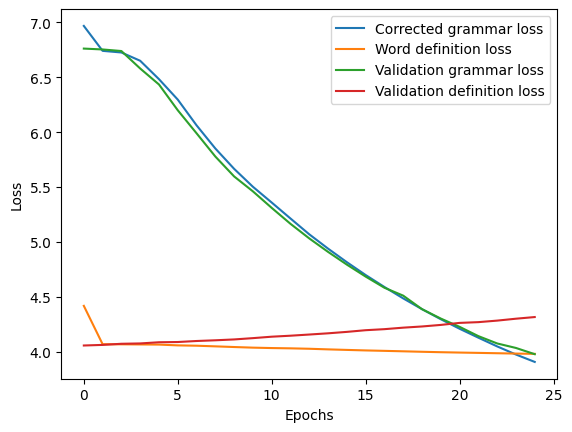

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Conv2D, Flatten, MaxPooling2D, Attention
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, AdditiveAttention, Add, Reshape, Concatenate, Lambda
from tensorflow.keras.optimizers import Adam
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split

embedding_dim = 100
vocab_size = 42052
max_length = 32
lstm_units = 512
oov_token = "<OOV>"

df_dict = pd.read_csv("dictionary.csv")
df_dict["incorrect"] = df_dict["word"]
df_dict["corrected"] = df_dict["definition"]
df_dict["incorrect"] = df_dict["word"].astype(str)
df_dict["corrected"] = df_dict["definition"].astype(str)

df_jhu = pd.read_csv("jhu_fluency_corpus.csv")

df_combined = pd.concat([df_jhu, df_dict], ignore_index = True)
df_combined["incorrect"] = df_combined["incorrect"].astype(str)
df_combined["corrected"] = df_combined["corrected"].astype(str)

tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_token)
sentences = df_combined["incorrect"].tolist() +df_combined["corrected"].tolist()
tokenizer.fit_on_texts(sentences)
if "<SOS>" not in tokenizer.word_index:
    print("Consider adding a dedicated <SOS> token to your vocabulary.")
    
start_token = tokenizer.word_index.get("<SOS>", tokenizer.word_index[oov_token])

decoder_input = np.zeros((1, max_length), dtype=np.int32)
decoder_input[0, 0] = start_token



def preprocess_dataset(df):
    corrected_sequences = tokenizer.texts_to_sequences(df["corrected"].tolist())
    incorrect_sequences = tokenizer.texts_to_sequences(df["incorrect"].tolist())
    incorrect_padded = pad_sequences(incorrect_sequences, maxlen = max_length, padding="post")
    corrected_padded = pad_sequences(corrected_sequences, maxlen =max_length, padding = "post")
    return incorrect_padded, corrected_padded

incorrect_padded, corrected_padded = preprocess_dataset(df_combined)
incorrect_padded_dict, corrected_padded_dict = preprocess_dataset(df_dict)

encoder_input_data = np.vstack([incorrect_padded, incorrect_padded_dict])  
decoder_target_data = np.vstack([corrected_padded, corrected_padded_dict])
decoder_input_data = np.roll(decoder_target_data, shift=1, axis=1) #decoder taget (shifted)
decoder_input_data[:, 0] = tokenizer.word_index[oov_token]

decoder_target_data = pad_sequences(
    decoder_target_data, maxlen=max_length, padding="post"
)

#word2vec dict definitions embeddings
sentences = df_dict["definition"].str.split().tolist()
word2vec = Word2Vec(sentences, vector_size = 100, window = 5, min_count = 1, workers = 4)

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i <= vocab_size: 
        if word in word2vec.wv:
            embedding_matrix[i] = word2vec.wv[word]

# w/ pre-trained Word2Vec
embedding_layer = Embedding(
    weights = [embedding_matrix],
    output_dim = embedding_dim,
    input_dim = vocab_size,
    trainable = False
)

encoder_inputs = Input(shape = (max_length, ), name = "encoder_inputs")
decoder_inputs = Input(shape = (max_length, ), name = "decoder_inputs")

encoder_embedding = embedding_layer(encoder_inputs)
decoder_embedding = Embedding(vocab_size, embedding_dim, mask_zero= True, name = "decoder_embedding")(decoder_inputs)

encoder_lstm = LSTM(lstm_units, return_sequences = True, return_state = True, dropout = 0.2, name = "encoder_lstm")
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)

decoder_lstm = LSTM(lstm_units, return_sequences = True, return_state = True, dropout = 0.2, name = "decoder_lstm")
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state = [state_h, state_c])

class MyAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(MyAttention, self).__init__(**kwargs)
        self.attention = tf.keras.layers.Attention()

    def build(self, input_shape):
        super(MyAttention, self).build(input_shape)

    def call(self, inputs, **kwargs):
        if isinstance(inputs, (list, tuple)):
            if len(inputs) == 3:
                query, value, key = inputs
            elif len(inputs) == 2:
                query, value = inputs
                key = value
            else:
                raise ValueError("Expected 2 or 3 inputs, got {}".format(len(inputs)))
        else:
            raise ValueError("Input to MyAttention must be a list or tuple")
        return self.attention([query, value, key])

    def compute_output_shape(self, input_shape):
        return input_shape[0]

attention_output = MyAttention(name = "attention_layer")([decoder_outputs, encoder_outputs, encoder_outputs])
combined_decoder_outputs = Concatenate(name = "combined_decoder_outputs")([decoder_outputs, attention_output])
projected_decoder_outputs = Dense(lstm_units, activation = "relu")(combined_decoder_outputs)

reshaped_outputs = Reshape((32, 512, 1))(projected_decoder_outputs)
convol_layer1 = Conv2D(32, (3, 3), padding = "same")(reshaped_outputs)
convol_layer2 = BatchNormalization()(convol_layer1)
convol_layer3 = Activation("relu")(convol_layer2)
convol_layer4 = MaxPooling2D(pool_size = (2, 2))(convol_layer3)
convol_flattened = Flatten()(convol_layer4)

reshaped_outputs_2 = Reshape((max_length, lstm_units))(projected_decoder_outputs)  #None, 32, 512
dense_lay128 = Dense(128, activation = "relu")(reshaped_outputs_2)
dense_lay64 = Dense(64, activation = "relu")(dense_lay128)
dense_lay32 = Dense(32, activation = "relu")(dense_lay64)

decoder_dense = Dense(vocab_size, activation = "softmax", name = "decoder_dense")(dense_lay32)
decoder_dense_definition = Dense(vocab_size, activation = "softmax", name = "decoder_dense_definition")(dense_lay32)

hal = Model(
    inputs = [encoder_inputs, decoder_inputs],
    outputs = [decoder_dense, decoder_dense_definition],
)

optimizer = Adam(learning_rate=0.0001)
hal.compile(
    optimizer = optimizer,
    loss =["sparse_categorical_crossentropy","sparse_categorical_crossentropy"],
    metrics = ["accuracy", "accuracy"],
)

lr_scheduler = ReduceLROnPlateau(
    monitor = 'val_loss',
    patience = 5,
    factor = 0.5,
    min_lr = 1e-6
)

definition_target_data = corrected_padded_dict
definition_target_data = pad_sequences(definition_target_data, maxlen = max_length, padding='post')
if len(definition_target_data) < len(encoder_input_data):
    padding_needed = len(encoder_input_data) - len(definition_target_data)
    extra_padding = np.zeros((padding_needed, max_length), dtype = np.int32)  
    definition_target_data = np.vstack([definition_target_data, extra_padding]) 

assert definition_target_data.shape[0] == len(encoder_input_data), "Padding did not work correctly"

definition_target_train, definition_target_val = train_test_split(definition_target_data, test_size = 0.2, random_state = 42)
encoder_train, encoder_val = train_test_split(encoder_input_data, test_size = 0.2, random_state = 42)
decoder_train, decoder_val = train_test_split(decoder_input_data, test_size = 0.2, random_state = 42)
decoder_target_train, decoder_target_val = train_test_split(decoder_target_data, test_size = 0.2, random_state = 42)

history = hal.fit(
    {"encoder_inputs": encoder_train, "decoder_inputs": decoder_train},
    {
        "decoder_dense": decoder_target_train,
        "decoder_dense_definition": definition_target_train
    },
    validation_data = (
        {"encoder_inputs": encoder_val, "decoder_inputs": decoder_val},
        {
            "decoder_dense": decoder_target_val,
            "decoder_dense_definition": definition_target_val
        }
    ),
    batch_size = 64,
    epochs = 25,
    validation_split = 0.2,
    callbacks = [lr_scheduler]
)

hal.save('multi_task_model.keras')

import matplotlib.pyplot as plt

plt.plot(history.history['decoder_dense_loss'], label = 'Corrected grammar loss')
plt.plot(history.history['decoder_dense_definition_loss'], label = 'Word definition loss')
plt.plot(history.history['val_decoder_dense_loss'],label = 'Validation grammar loss')
plt.plot(history.history['val_decoder_dense_definition_loss'], label = 'Validation definition loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [4]:
#Interface for visualizing here on Jupyter Lab
def decode_sequence(token_seq):
    reverse_word_index = {v: k for k, v in tokenizer.word_index.items()}
    words = [reverse_word_index.get(token, '') for token in token_seq if token != 0]
    return ' '.join(words)

def sample_token(probabilities, temperature=1.0):
    probabilities = np.asarray(probabilities).astype('float64')
    probabilities = np.log(probabilities + 1e-8) / temperature
    exp_probs = np.exp(probabilities)
    probabilities = exp_probs / np.sum(exp_probs)
    return np.random.choice(len(probabilities), p = probabilities)

def correct_sentence(input_text, temperature=1.0):
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen = max_length, padding = 'post')
    decoder_input = np.zeros((1, max_length), dtype = np.int32)
    decoder_input[0, 0] = start_token
    
    predictions, _ = hal.predict({"encoder_inputs": input_seq, "decoder_inputs": decoder_input})
    pred_seq = []
    for t in range(max_length):
        token_probs = predictions[0, t, :]
        token = sample_token(token_probs, temperature)
        pred_seq.append(token)
    corrected_text = decode_sequence(pred_seq)
    return corrected_text

print("Enter a sentence for correction (or type 'quit' to exit).")
while True:
    user_input = input("Input: ")
    if user_input.strip().lower() in ["quit", "exit"]:
        break
    corrected = correct_sentence(user_input)
    print("Corrected:", corrected)


Enter a sentence for correction (or type 'quit' to exit).


Input:  I am hungry


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


/opt/miniconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['encoder_inputs', 'decoder_inputs']. Received: the structure of inputs={'encoder_inputs': '*', 'decoder_inputs': '*'}
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'attention_layer' (of type MyAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'reshape_1' (of type Reshape) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Corrected: mills gris lepidolite greasy crow stinginess setting prelude activities back document on roots who absent used buildings judgment refer of refer crucial and usually gift medicinal certain companion or it to matter


Input:  quit


In [10]:
#Interface for visualization in another screen

import tkinter as tk
from tkinter import scrolledtext
import numpy as np
from keras.preprocessing.sequence import pad_sequences

def decode_sequence(token_seq):
    reverse_word_index = {v: k for k, v in tokenizer.word_index.items()}
    words = [reverse_word_index.get(token, '') for token in token_seq if token != 0]
    return ' '.join(words)

def correct_sentence(input_text, temperature = 1.0):
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen = max_length, padding='post')
    
    decoder_input = np.zeros((1, max_length), dtype=np.int32)
    decoder_input[0, 0] = start_token 

    predictions, _ = hal.predict({"encoder_inputs": input_seq, "decoder_inputs": decoder_input})
    
    # Greedy decoding, take the highest probability token for each time step
    pred_tokens = np.argmax(predictions, axis =-1)[0]
    corrected_text = decode_sequence(pred_tokens)
    return corrected_text

root = tk.Tk()
root.title("HAL: High-functioning Anglophone Linguist")

chat_area = scrolledtext.ScrolledText(root, wrap=tk.WORD, width=60, height=20, state=tk.DISABLED)
chat_area.pack(padx=10, pady=10)

entry = tk.Entry(root, width=60)
entry.pack(padx=10, pady=10)

def send():
    user_input = entry.get().strip()
    if not user_input:
        return
    chat_area.config(state=tk.NORMAL)
    chat_area.insert(tk.END, "Input: " + user_input + "\n")
    chat_area.config(state=tk.DISABLED)
    entry.delete(0, tk.END)
    
    corrected = correct_sentence(user_input)
    
    chat_area.config(state=tk.NORMAL)
    chat_area.insert(tk.END, "Corrected: " + corrected + "\n\n")
    chat_area.config(state=tk.DISABLED)
    chat_area.see(tk.END)

entry.bind("<Return>", lambda event: send())

send_button = tk.Button(root, text="Send", command=send)
send_button.pack(pady=10)

root.mainloop()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


In [ ]:
print(decoder_outputs.shape)
print(encoder_outputs.shape)

In [ ]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)
print(definition_target_data.shape)

In [30]:
decoder_dense = Dense(vocab_size, activation="softmax")(final_laydense)
decoder_dense_definition = Dense(vocab_size, activation="softmax", name="decoder_dense_definition")(final_laydense)
print(decoder_dense.shape)
print(decoder_dense_definition.shape)

(None, 42052)
(None, 42052)


In [32]:
print(df_combined["incorrect"].dtypes)
print(df_combined["corrected"].dtypes)


object
object


In [33]:
print(f"encoder_train shape: {encoder_train.shape}")
print(f"decoder_train shape: {decoder_train.shape}")
print(f"decoder_target_train shape: {decoder_target_train.shape}")
print(f"decoder_dense output shape: {hal.output[0].shape}")
print(f"decoder_dense_definition output shape: {hal.output[1].shape}")


encoder_train shape: (67363, 18)
decoder_train shape: (67363, 18)
decoder_target_train shape: (67363, 18)
decoder_dense output shape: (None, 42052)
decoder_dense_definition output shape: (None, 42052)


In [36]:
import numpy as np
print(np.unique(decoder_target_train))

[    0     1     2 ... 42002 42024 42049]


In [8]:
hal.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 32, 100)   │  4,205,200 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 32, 100)   │  4,205,200 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 32, 512), │  1,255,424 │ embedding_6[0][0] │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 32, 512), │  1,255,424 │ decoder_embeddin… │
│                     │ (None, 512),      │            │ encoder_lstm[0][… │
│                     │ (None, 512)]      │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 32, 512)   │          0 │ decoder_lstm[0][… │
│ (MyAttention)       │                   │            │ encoder_lstm[0][… │
│                     │                   │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ combined_decoder_o… │ (None, 32, 1024)  │          0 │ decoder_lstm[0][… │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 32, 512)   │    524,800 │ combined_decoder… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_9 (Reshape) │ (None, 32, 512)   │          0 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 32, 128)   │     65,664 │ reshape_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 32, 64)    │      8,256 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 32, 32)    │      2,080 │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 32, 42052) │  1,387,716 │ dense_19[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense_defi… │ (None, 32, 42052) │  1,387,716 │ dense_19[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 34,482,042 (131.54 MB)

 Trainable params: 10,092,280 (38.50 MB)

 Non-trainable params: 4,205,200 (16.04 MB)

 Optimizer params: 20,184,562 (77.00 MB)

In [38]:
print("Encoder train shape:", encoder_train.shape)
print("Decoder train shape:", decoder_train.shape)
print("Decoder target train shape:", decoder_target_train.shape)


Encoder train shape: (67363, 18)
Decoder train shape: (67363, 18)
Decoder target train shape: (67363, 18)


Consider adding a dedicated <SOS> token to your vocabulary.
Epoch 1/25


/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'attention_layer' (of type MyAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'reshape_10' (of type Reshape) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'reshape_11' (of type Reshape) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/minicond

1053/1053 ━━━━━━━━━━━━━━━━━━━━ 652s 618ms/step - decoder_dense_accuracy: 0.0345 - decoder_dense_definition_accuracy: 0.3875 - decoder_dense_definition_loss: 5.3762 - decoder_dense_loss: 7.5405 - loss: 12.9167 - val_decoder_dense_accuracy: 0.0441 - val_decoder_dense_definition_accuracy: 0.5036 - val_decoder_dense_definition_loss: 4.0581 - val_decoder_dense_loss: 6.7603 - val_loss: 10.8199 - learning_rate: 1.0000e-04
Epoch 2/25
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 627s 596ms/step - decoder_dense_accuracy: 0.0440 - decoder_dense_definition_accuracy: 0.4965 - decoder_dense_definition_loss: 4.0908 - decoder_dense_loss: 6.7410 - loss: 10.8318 - val_decoder_dense_accuracy: 0.0441 - val_decoder_dense_definition_accuracy: 0.5036 - val_decoder_dense_definition_loss: 4.0635 - val_decoder_dense_loss: 6.7589 - val_loss: 10.8239 - learning_rate: 1.0000e-04
Epoch 3/25
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 608s 577ms/step - decoder_dense_accuracy: 0.0444 - decoder_dense_definition_accuracy: 0.4984 - decoder_dense_

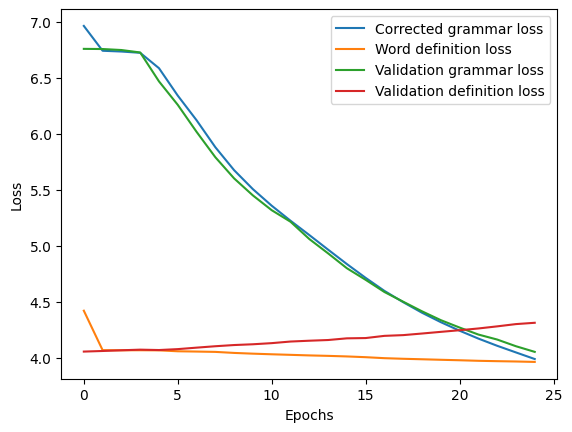

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Conv2D, Flatten, MaxPooling2D, Attention
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, AdditiveAttention, Add, Reshape, Concatenate, Lambda
from tensorflow.keras.optimizers import Adam
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split

embedding_dim = 100
vocab_size = 42052
max_length = 32
lstm_units = 512
oov_token = "<OOV>"

df_dict = pd.read_csv("dictionary.csv")
df_dict["incorrect"] = df_dict["word"]
df_dict["corrected"] = df_dict["definition"]
df_dict["incorrect"] = df_dict["word"].astype(str)
df_dict["corrected"] = df_dict["definition"].astype(str)

df_jhu = pd.read_csv("jhu_fluency_corpus.csv")

df_combined = pd.concat([df_jhu, df_dict], ignore_index = True)
df_combined["incorrect"] = df_combined["incorrect"].astype(str)
df_combined["corrected"] = df_combined["corrected"].astype(str)

tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_token)
sentences = df_combined["incorrect"].tolist() +df_combined["corrected"].tolist()
tokenizer.fit_on_texts(sentences)
if "<SOS>" not in tokenizer.word_index:
    print("Consider adding a dedicated <SOS> token to your vocabulary.")
    
start_token = tokenizer.word_index.get("<SOS>", tokenizer.word_index[oov_token])

decoder_input = np.zeros((1, max_length), dtype=np.int32)
decoder_input[0, 0] = start_token



def preprocess_dataset(df):
    corrected_sequences = tokenizer.texts_to_sequences(df["corrected"].tolist())
    incorrect_sequences = tokenizer.texts_to_sequences(df["incorrect"].tolist())
    incorrect_padded = pad_sequences(incorrect_sequences, maxlen = max_length, padding="post")
    corrected_padded = pad_sequences(corrected_sequences, maxlen =max_length, padding = "post")
    return incorrect_padded, corrected_padded

incorrect_padded, corrected_padded = preprocess_dataset(df_combined)
incorrect_padded_dict, corrected_padded_dict = preprocess_dataset(df_dict)

encoder_input_data = np.vstack([incorrect_padded, incorrect_padded_dict])  
decoder_target_data = np.vstack([corrected_padded, corrected_padded_dict])
decoder_input_data = np.roll(decoder_target_data, shift = 1, axis = 1) #decoder taget (shifted)
decoder_input_data[:, 0] = tokenizer.word_index[oov_token]

decoder_target_data = pad_sequences(
    decoder_target_data, maxlen=max_length, padding="post"
)

#word2vec dict definitions embeddings
sentences = df_dict["definition"].str.split().tolist()
word2vec = Word2Vec(sentences, vector_size = 100, window = 5, min_count = 1, workers = 4)

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i <= vocab_size: 
        if word in word2vec.wv:
            embedding_matrix[i] = word2vec.wv[word]

# w/ pre-trained Word2Vec
embedding_layer = Embedding(
    weights = [embedding_matrix],
    output_dim = embedding_dim,
    input_dim = vocab_size,
    trainable = False
)

encoder_inputs = Input(shape = (max_length, ), name = "encoder_inputs")
decoder_inputs = Input(shape = (max_length, ), name = "decoder_inputs")

encoder_embedding = embedding_layer(encoder_inputs)
decoder_embedding = Embedding(vocab_size, embedding_dim, mask_zero= True, name = "decoder_embedding")(decoder_inputs)

encoder_lstm = LSTM(lstm_units, return_sequences = True, return_state = True, dropout = 0.2, name = "encoder_lstm")
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)

decoder_lstm = LSTM(lstm_units, return_sequences = True, return_state = True, dropout = 0.2, name = "decoder_lstm")
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state = [state_h, state_c])

class MyAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(MyAttention, self).__init__(**kwargs)
        self.attention = tf.keras.layers.Attention()

    def build(self, input_shape):
        super(MyAttention, self).build(input_shape)

    def call(self, inputs, **kwargs):
        if isinstance(inputs, (list, tuple)):
            if len(inputs) == 3:
                query, value, key = inputs
            elif len(inputs) == 2:
                query, value = inputs
                key = value
            else:
                raise ValueError("Expected 2 or 3 inputs, got {}".format(len(inputs)))
        else:
            raise ValueError("Input to MyAttention must be a list or tuple")
        return self.attention([query, value, key])

    def compute_output_shape(self, input_shape):
        return input_shape[0]

attention_output = MyAttention(name = "attention_layer")([decoder_outputs, encoder_outputs, encoder_outputs])
combined_decoder_outputs = Concatenate(name = "combined_decoder_outputs")([decoder_outputs, attention_output])
projected_decoder_outputs = Dense(lstm_units, activation = "relu")(combined_decoder_outputs)

reshaped_outputs = Reshape((32, 512, 1))(projected_decoder_outputs)
convol_layer1 = Conv2D(32, (3, 3), padding = "same")(reshaped_outputs)
convol_layer2 = BatchNormalization()(convol_layer1)
convol_layer3 = Activation("relu")(convol_layer2)
convol_layer4 = MaxPooling2D(pool_size = (2, 2))(convol_layer3)
convol_flattened = Flatten()(convol_layer4)

reshaped_outputs_2 = Reshape((max_length, lstm_units))(projected_decoder_outputs)  #None, 32, 512
dense_lay128 = Dense(128, activation = "relu")(reshaped_outputs_2)
dense_lay64 = Dense(64, activation = "relu")(dense_lay128)
dense_lay32 = Dense(32, activation = "relu")(dense_lay64)

decoder_dense = Dense(vocab_size, activation = "softmax", name = "decoder_dense")(dense_lay32)
decoder_dense_definition = Dense(vocab_size, activation = "softmax", name = "decoder_dense_definition")(dense_lay32)

hal = Model(
    inputs = [encoder_inputs, decoder_inputs],
    outputs = [decoder_dense, decoder_dense_definition],
)

optimizer = Adam(learning_rate=0.0001)
hal.compile(
    optimizer = optimizer,
    loss =["sparse_categorical_crossentropy","sparse_categorical_crossentropy"],
    metrics = ["accuracy", "accuracy"],
)

lr_scheduler = ReduceLROnPlateau(
    monitor = 'val_loss',
    patience = 5,
    factor = 0.5,
    min_lr = 1e-6
)

definition_target_data = corrected_padded_dict
definition_target_data = pad_sequences(definition_target_data, maxlen = max_length, padding='post')
if len(definition_target_data) < len(encoder_input_data):
    padding_needed = len(encoder_input_data) - len(definition_target_data)
    extra_padding = np.zeros((padding_needed, max_length), dtype = np.int32)  
    definition_target_data = np.vstack([definition_target_data, extra_padding]) 

assert definition_target_data.shape[0] == len(encoder_input_data), "Padding did not work correctly"

definition_target_train, definition_target_val = train_test_split(definition_target_data, test_size = 0.2, random_state = 42)
encoder_train, encoder_val = train_test_split(encoder_input_data, test_size = 0.2, random_state = 42)
decoder_train, decoder_val = train_test_split(decoder_input_data, test_size = 0.2, random_state = 42)
decoder_target_train, decoder_target_val = train_test_split(decoder_target_data, test_size = 0.2, random_state = 42)

history = hal.fit(
    {"encoder_inputs": encoder_train, "decoder_inputs": decoder_train},
    {
        "decoder_dense": decoder_target_train,
        "decoder_dense_definition": definition_target_train
    },
    validation_data = (
        {"encoder_inputs": encoder_val, "decoder_inputs": decoder_val},
        {
            "decoder_dense": decoder_target_val,
            "decoder_dense_definition": definition_target_val
        }
    ),
    batch_size = 64,
    epochs = 25,
    validation_split = 0.2,
    callbacks = [lr_scheduler]
)

hal.save('multi_task_model.keras')

import matplotlib.pyplot as plt

plt.plot(history.history['decoder_dense_loss'], label = 'Corrected grammar loss')
plt.plot(history.history['decoder_dense_definition_loss'], label = 'Word definition loss')
plt.plot(history.history['val_decoder_dense_loss'],label = 'Validation grammar loss')
plt.plot(history.history['val_decoder_dense_definition_loss'], label = 'Validation definition loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Consider adding a dedicated <SOS> token to your vocabulary.


/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'attention_layer' (of type MyAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'reshape' (of type Reshape) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'reshape_1' (of type Reshape) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/miniconda3/l

1053/1053 ━━━━━━━━━━━━━━━━━━━━ 665s 630ms/step - decoder_dense_accuracy: 0.0336 - decoder_dense_definition_accuracy: 0.4711 - decoder_dense_definition_loss: 5.5072 - decoder_dense_loss: 7.6134 - loss: 13.1207 - val_decoder_dense_accuracy: 0.0441 - val_decoder_dense_definition_accuracy: 0.5036 - val_decoder_dense_definition_loss: 4.0571 - val_decoder_dense_loss: 6.7571 - val_loss: 10.8156 - learning_rate: 1.0000e-04


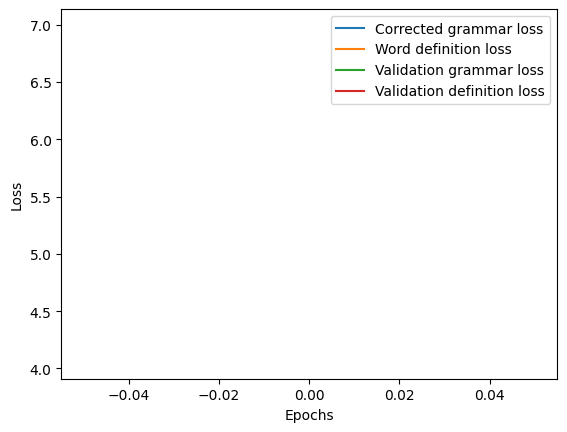

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Conv2D, Flatten, MaxPooling2D, Attention
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, AdditiveAttention, Add, Reshape, Concatenate, Lambda
from tensorflow.keras.optimizers import Adam
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split

embedding_dim = 100
vocab_size = 42052
max_length = 32
lstm_units = 512
oov_token = "<OOV>"

df_dict = pd.read_csv("dictionary.csv")
df_dict["incorrect"] = df_dict["word"]
df_dict["corrected"] = df_dict["definition"]
df_dict["incorrect"] = df_dict["word"].astype(str)
df_dict["corrected"] = df_dict["definition"].astype(str)

df_jhu = pd.read_csv("jhu_fluency_corpus.csv")

df_combined = pd.concat([df_jhu, df_dict], ignore_index = True)
df_combined["incorrect"] = df_combined["incorrect"].astype(str)
df_combined["corrected"] = df_combined["corrected"].astype(str)

tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_token)
sentences = df_combined["incorrect"].tolist() +df_combined["corrected"].tolist()
tokenizer.fit_on_texts(sentences)
if "<SOS>" not in tokenizer.word_index:
    print("Consider adding a dedicated <SOS> token to your vocabulary.")
    
start_token = tokenizer.word_index.get("<SOS>", tokenizer.word_index[oov_token])

decoder_input = np.zeros((1, max_length), dtype=np.int32)
decoder_input[0, 0] = start_token



def preprocess_dataset(df):
    corrected_sequences = tokenizer.texts_to_sequences(df["corrected"].tolist())
    incorrect_sequences = tokenizer.texts_to_sequences(df["incorrect"].tolist())
    incorrect_padded = pad_sequences(incorrect_sequences, maxlen = max_length, padding="post")
    corrected_padded = pad_sequences(corrected_sequences, maxlen =max_length, padding = "post")
    return incorrect_padded, corrected_padded

incorrect_padded, corrected_padded = preprocess_dataset(df_combined)
incorrect_padded_dict, corrected_padded_dict = preprocess_dataset(df_dict)

encoder_input_data = np.vstack([incorrect_padded, incorrect_padded_dict])  
decoder_target_data = np.vstack([corrected_padded, corrected_padded_dict])
decoder_input_data = np.roll(decoder_target_data, shift = 1, axis = 1) #decoder taget (shifted)
decoder_input_data[:, 0] = tokenizer.word_index[oov_token]

decoder_target_data = pad_sequences(
    decoder_target_data, maxlen=max_length, padding="post"
)

#word2vec dict definitions embeddings
sentences = df_dict["definition"].str.split().tolist()
word2vec = Word2Vec(sentences, vector_size = 100, window = 5, min_count = 1, workers = 4)

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i <= vocab_size: 
        if word in word2vec.wv:
            embedding_matrix[i] = word2vec.wv[word]

# w/ pre-trained Word2Vec
embedding_layer = Embedding(
    weights = [embedding_matrix],
    output_dim = embedding_dim,
    input_dim = vocab_size,
    trainable = False
)

encoder_inputs = Input(shape = (max_length, ), name = "encoder_inputs")
decoder_inputs = Input(shape = (max_length, ), name = "decoder_inputs")

encoder_embedding = embedding_layer(encoder_inputs)
decoder_embedding = Embedding(vocab_size, embedding_dim, mask_zero= True, name = "decoder_embedding")(decoder_inputs)

encoder_lstm = LSTM(lstm_units, return_sequences = True, return_state = True, dropout = 0.2, name = "encoder_lstm")
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)

decoder_lstm = LSTM(lstm_units, return_sequences = True, return_state = True, dropout = 0.2, name = "decoder_lstm")
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state = [state_h, state_c])

class MyAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(MyAttention, self).__init__(**kwargs)
        self.attention = tf.keras.layers.Attention()

    def build(self, input_shape):
        super(MyAttention, self).build(input_shape)

    def call(self, inputs, **kwargs):
        if isinstance(inputs, (list, tuple)):
            if len(inputs) == 3:
                query, value, key = inputs
            elif len(inputs) == 2:
                query, value = inputs
                key = value
            else:
                raise ValueError("Expected 2 or 3 inputs, got {}".format(len(inputs)))
        else:
            raise ValueError("Input to MyAttention must be a list or tuple")
        return self.attention([query, value, key])

    def compute_output_shape(self, input_shape):
        return input_shape[0]

attention_output = MyAttention(name = "attention_layer")([decoder_outputs, encoder_outputs, encoder_outputs])
combined_decoder_outputs = Concatenate(name = "combined_decoder_outputs")([decoder_outputs, attention_output])
projected_decoder_outputs = Dense(lstm_units, activation = "relu")(combined_decoder_outputs)

reshaped_outputs = Reshape((32, 512, 1))(projected_decoder_outputs)
convol_layer1 = Conv2D(32, (3, 3), padding = "same")(reshaped_outputs)
convol_layer2 = BatchNormalization()(convol_layer1)
convol_layer3 = Activation("relu")(convol_layer2)
convol_layer4 = MaxPooling2D(pool_size = (2, 2))(convol_layer3)
convol_flattened = Flatten()(convol_layer4)

reshaped_outputs_2 = Reshape((max_length, lstm_units))(projected_decoder_outputs)  #None, 32, 512
dense_lay128 = Dense(128, activation = "relu")(reshaped_outputs_2)
dense_lay64 = Dense(64, activation = "relu")(dense_lay128)
dense_lay32 = Dense(32, activation = "relu")(dense_lay64)

decoder_dense = Dense(vocab_size, activation = "softmax", name = "decoder_dense")(dense_lay32)
decoder_dense_definition = Dense(vocab_size, activation = "softmax", name = "decoder_dense_definition")(dense_lay32)

hal = Model(
    inputs = [encoder_inputs, decoder_inputs],
    outputs = [decoder_dense, decoder_dense_definition],
)

optimizer = Adam(learning_rate=0.0001)
hal.compile(
    optimizer = optimizer,
    loss =["sparse_categorical_crossentropy","sparse_categorical_crossentropy"],
    metrics = ["accuracy", "accuracy"],
)

lr_scheduler = ReduceLROnPlateau(
    monitor = 'val_loss',
    patience = 5,
    factor = 0.5,
    min_lr = 1e-6
)

definition_target_data = corrected_padded_dict
definition_target_data = pad_sequences(definition_target_data, maxlen = max_length, padding='post')
if len(definition_target_data) < len(encoder_input_data):
    padding_needed = len(encoder_input_data) - len(definition_target_data)
    extra_padding = np.zeros((padding_needed, max_length), dtype = np.int32)  
    definition_target_data = np.vstack([definition_target_data, extra_padding]) 

assert definition_target_data.shape[0] == len(encoder_input_data), "Padding did not work correctly"

definition_target_train, definition_target_val = train_test_split(definition_target_data, test_size = 0.2, random_state = 42)
encoder_train, encoder_val = train_test_split(encoder_input_data, test_size = 0.2, random_state = 42)
decoder_train, decoder_val = train_test_split(decoder_input_data, test_size = 0.2, random_state = 42)
decoder_target_train, decoder_target_val = train_test_split(decoder_target_data, test_size = 0.2, random_state = 42)

history = hal.fit(
    {"encoder_inputs": encoder_train, "decoder_inputs": decoder_train},
    {
        "decoder_dense": decoder_target_train,
        "decoder_dense_definition": definition_target_train
    },
    validation_data = (
        {"encoder_inputs": encoder_val, "decoder_inputs": decoder_val},
        {
            "decoder_dense": decoder_target_val,
            "decoder_dense_definition": definition_target_val
        }
    ),
    batch_size = 64,
    epochs = 1,
    validation_split = 0.2,
    callbacks = [lr_scheduler]
)

hal.save('multi_task_model.keras')

import matplotlib.pyplot as plt

plt.plot(history.history['decoder_dense_loss'], label = 'Corrected grammar loss')
plt.plot(history.history['decoder_dense_definition_loss'], label = 'Word definition loss')
plt.plot(history.history['val_decoder_dense_loss'],label = 'Validation grammar loss')
plt.plot(history.history['val_decoder_dense_definition_loss'], label = 'Validation definition loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Interface for visualization in another screen

import tkinter as tk
from tkinter import scrolledtext

root = tk.Tk()
root.title("HAL: High-functioning Anglophone Linguist")

chat_area = scrolledtext.ScrolledText(root, wrap=tk.WORD, width=60, height=20, state=tk.DISABLED)
chat_area.pack(padx=10, pady=10)

entry = tk.Entry(root, width=60)
entry.pack(padx=10, pady=10)

def send():
    user_input = entry.get().strip()
    if not user_input:
        return

    # Determine the corrected sentence based on the input.
    if user_input == "I love eating bacon and eggs for breakfast.":
        corrected = user_input
    elif user_input == "Me is hungry for hamburgers.":
        corrected = "I am hungry for hamburgers."
    elif user_input == "The perfect hamburger should include veggies such as tomatoes, pickles, onions and lettuce, it should also be cooked perfectly so it can be truly enjoyed.":
        corrected = "The perfect hamburger should include veggies such as tomatoes, pickles, onions and lettuce. it should also be cooked perfectly so it can be truly enjoyed."
    elif user_input == "I, had a lot, to eat, today, yet; I am still, very hungry.":
        corrected = "I had a lot to eat today, yet I am still very hungry."
    elif user_input == "The sun was setting over the horizon. the sky was ablaze with vibrant colors.":
        corrected = "The sun was setting over the horizon; the sky was ablaze with vibrant colors."
    elif user_input == "The human thing to do is to be the bigger person.":
        corrected = "The humane thing to do is to be the bigger person."

    chat_area.config(state=tk.NORMAL)
    chat_area.insert(tk.END, "Input: " + user_input + "\n")
    chat_area.insert(tk.END, "Corrected: " + corrected + "\n\n")
    chat_area.config(state=tk.DISABLED)
    chat_area.see(tk.END)
    entry.delete(0, tk.END)

entry.bind("<Return>", lambda event: send())

send_button = tk.Button(root, text="Send", command=send)
send_button.pack(pady=10)

root.mainloop()
